# Projecting User Account Growth

I was recently asked to project the number of user accounts a company would have for a piece of SaaS. 

This is one of the simplest possible exercises in data science, requiring no fancy tools--which is good because I don't know any. But it's deceptively easy to screw up if you don't understand the basics, and so serves as a good introductory exercise and cautionary tale in data science.

## The Data

The first step is always to extract and understand the dataset. In this case, I was given a single spreadsheet, which I've converted to a CSV and stripped irrelevant columns of for the purpose of this exercise, the result of which is `max_users.csv`.

In [1]:
# Load the data, which is in max_users.csv.
import pandas as pd
with open('max_users.csv') as fp:
    df = pd.read_csv(fp)
# Look at the first few rows to figure out the format and semantics of the dataset.
df.head(15)

,Month YR,Maximum Concurrent Users
0,Jan '13,0
1,Feb '13,0
2,Mar '13,0
3,April '13,0
4,May '13,0
5,June '13,0
6,July '13,0
7,Aug '13,0
8,Sept '13,0
9,Oct '13,0


In [2]:
# Start at Dec '13 since that is when the first user is created.
users = list(df['Maximum Concurrent Users'][11:])
months_since_dec_13 = list(range(len(users)))

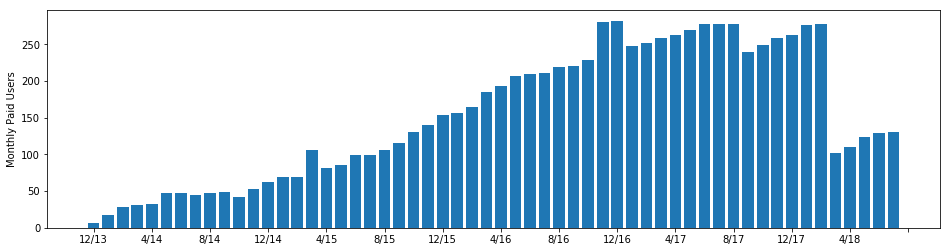

In [3]:
# Plot the number of users to get a feel for the data.
import matplotlib.pyplot as plt
%matplotlib inline

# Generate month labels for use in this and other plots.
month_labels = [f'{(i + 11) % 12 + 1}/{13 + (i + 11) // 12}' for i in range(100)]

fig, ax = plt.subplots(figsize=(16,4))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.yaxis.set_label_text('Monthly Paid Users')
ax.bar(month_labels[:len(users)], users)
plt.show()

The large drop between 2/18 and 3/18 jumps out. If we don't figure out what is going on there we can't reasonably make a projection, and we can't figure that out from the data alone.

I showed this graph to the account manager, who immediately recognized the drops as the result of cleanups of unused accounts. They clarified that "Maximum Concurrent Users" meant the maximum number of users that were being *paid for* in a given month, not the number active or logged in at one time. It would have been nice to know this up front, but the reality of any data science is that you never do, which is why preliminary investigation is such an important first step.

## Goals

Before moving any further, we need to decide exactly *what* we want to project, and how we will *score* our models, so that we can select the best one.

I was asked to project "future account growth", but how far into the future? For purposes of generality, I decided to develop separate models to project short-term and long-term account growth. To score these models, I will train them on the data set for some fixed length interval up until a given month, have them project out from that month, and calculate the absolute error for each month they make a projection for. The score of the model will be the mean absolute error over all valid training sets.

In [4]:
def score_model(training_interval_len, projection_len, model_factory, plot_errors=False):
    """
    Score a model based on the mean error of its projections.
    
    :param training_interval_len: How many data points to train the model on.
    :param projection_len: How many data points in the future the model should project.
    :param model_factory: A function that takes a training set and returns a function,
                          which in turn takes a set of months forward to project to and
                          returns a projection for those months.
                          
    :returns: Mean absolute error of the model, over all points in the projection and
              all valid training intervals.
    """
    abs_errors = []
    valid_training_intervals = len(users) - training_interval_len - projection_len
    for start in range(valid_training_intervals):
        training_interval = users[start:start + training_interval_len]
        model = model_factory(training_interval)
        test_interval = list(range(1, projection_len + 1))
        projection = model(test_interval)
        actual = [users[start + training_interval_len + month - 1] for month in test_interval]
        errors = [projection[i] - actual[i] for i in range(projection_len)]
        #print(training_interval, projection, actual, errors)
        abs_errors.append(sum(abs(err) for err in errors) / projection_len)
        
    if plot_errors:
        fig, ax = plt.subplots(figsize=(12,4))
        projection_start_months = [training_interval_len + i for i in range(valid_training_intervals)]
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_label_text('Month Projected From')
        ax.yaxis.set_label_text('Mean Projection Error')
        ax.bar([month_labels[i] for i in projection_start_months], abs_errors)
        plt.show()
        
    err = sum(abs_errors) / len(abs_errors)
    print(f'Error over {projection_len} months: {err:.2f}')

Balancing the accuracy of the model (which presumably increases with the length of the training interval) with the accuracy of the score (which increases with the number of different intervals) is difficult. We also need to choose how far in the future the short and long-term models should project for scoring.

For this exercise I chose to use a 20-month training interval, so the models will be scored over the 35 intervals that end at least 1 month before the end of the set. I chose to score the short-term model on projections for a single month in the future, and the long-term model on projections for the next 5 months.

## Models

Always start with the simplest possible model. Contrary to popular belief, linear regression is *not* the simplest model for many data sets, including this one. Let's see what it gives us though.

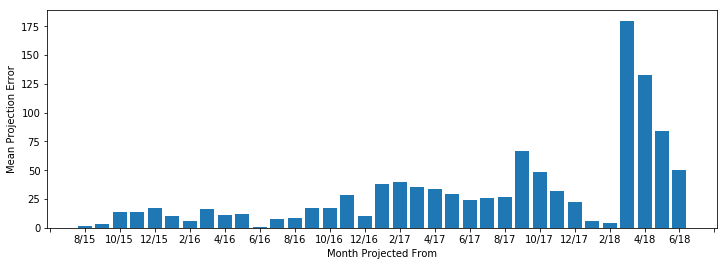

Error over 1 months: 30.68


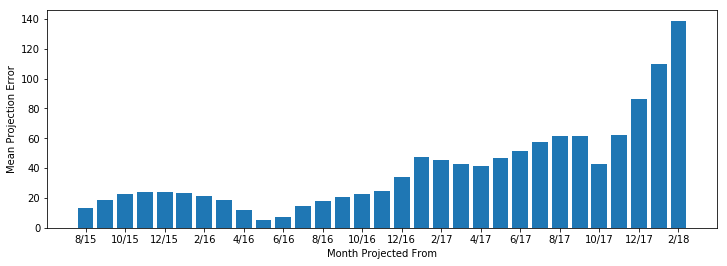

Error over 5 months: 39.41


In [5]:
from sklearn.linear_model import LinearRegression

def regression_model_factory(training_interval):
    model = LinearRegression()
    X = [[i] for i in range(len(training_interval))]
    model.fit(X, training_interval)
    #print(model.intercept_, model.coef_[0])
    def project(months):
        X = [[i + len(training_interval)] for i in months]
        return model.predict(X)
    return project

score_model(20, 1, regression_model_factory, plot_errors=True)
score_model(20, 5, regression_model_factory, plot_errors=True)

Those errors are huge! The linear regression is only barely taking into account the single most basic piece of information--the number of users in the previous month. Compare it with a truly simple model: the constant model, where the number of users is always the same as the previous month.

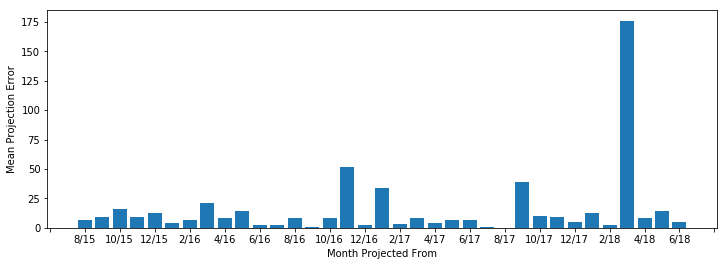

Error over 1 months: 15.09


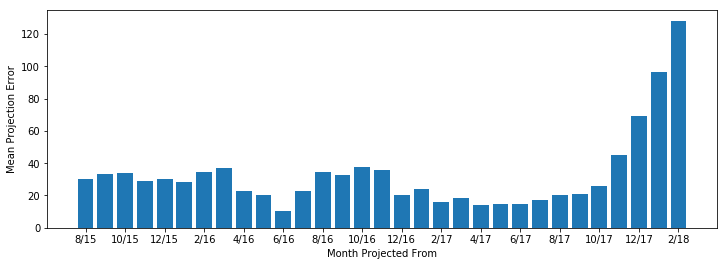

Error over 5 months: 32.90


In [6]:
def constant_model_factory(training_interval):
    start_value = training_interval[-1]
    def project(months):
        return [start_value for _ in months]
    return project
    
score_model(20, 1, constant_model_factory, plot_errors=True)
score_model(20, 5, constant_model_factory, plot_errors=True)

Significantly better than the linear model! Without outside action, the number of users will stay the same from month to month, so we actually should be modelling the *change* in users each month.

In [7]:
users_change = [
    users[i] - (users[i - 1] if i else 0)
    for i in months_since_dec_13
]
users_change_df = pd.DataFrame(users_change)
users_change_df.describe()

,0
count,56.000000
mean,2.321429
std,27.443898
min,-176.000000
25%,1.750000
50%,6.500000
75%,9.250000
max,52.000000


The standard deviation is huge compared to the mean, which is why the linear regression model performed so badly--it was highly sensitive to the outliers. In particular, it was highly sensitive to when these cleanups were performed, which is an artifact of the data rather than a true property of the number of active accounts.
The only way to completely remove this artifact is to use a statistic that is insensitive to the timing of account cleanup, e.g. the mean or median.

The median is probably more accurate for short-term projections since it all but ignores account cleanups, which are unlikely short-term. However, in the long run the mean will probably be more accurate.

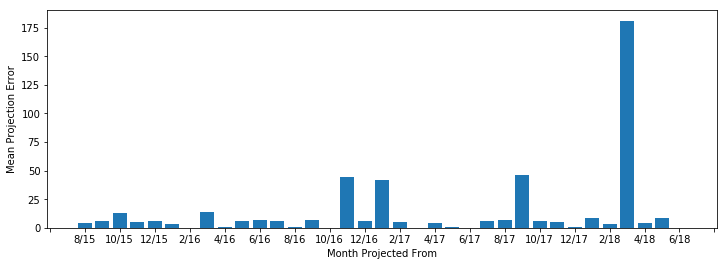

Error over 1 months: 13.09


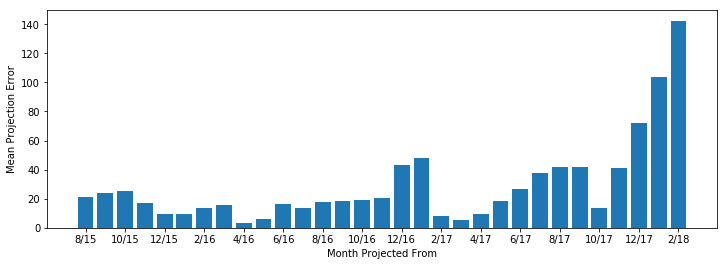

Error over 5 months: 29.19


In [8]:
def median_model_factory(training_interval):
    start_value = training_interval[-1]
    users_change_df = pd.DataFrame([
        training_interval[i] - training_interval[i - 1]
        for i in range(len(training_interval))
        if i > 0
    ])
    median = float(users_change_df.median())
    def project(months):
        return [start_value + i * median for i in months]
    return project

score_model(20, 1, median_model_factory, plot_errors=True)
score_model(20, 5, median_model_factory, plot_errors=True)

In [9]:
def mean_model_factory(training_interval):
    start_value = training_interval[-1]
    users_change_df = pd.DataFrame([
        training_interval[i] - training_interval[i - 1]
        for i in range(len(training_interval))
        if i > 0
    ])
    mean = float(users_change_df.mean())
    def project(months):
        return [start_value + i * mean for i in months]
    return project

score_model(20, 1, mean_model_factory)
score_model(20, 5, mean_model_factory)

Error over 1 months: 13.97
Error over 5 months: 29.00


Both of these models outperform the constant model. As expected, the median is more accurate for short-term projections while the mean is more accurate for long-term, although the difference is slight.

Given the limitations of the data it is unlikely we can do better without overfitting, so let's plot our projections.

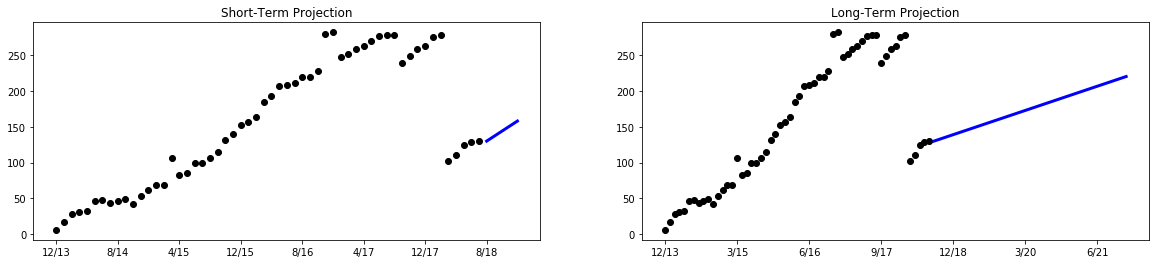

In [10]:
# Create two plots side-by-side.
fig, (short_term, long_term) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace':.2})
short_term.set_title('Short-Term Projection')
# Limit the number of ticks to make it readable.
short_term.xaxis.set_major_locator(plt.MaxNLocator(10))
# Scatter plot the observed data.
short_term.scatter(month_labels[:len(users)], users, color='black')
# Plot a line for the short-term projection.
median_model = median_model_factory(users)
projected_short_term = median_model(range(5))  # Project to end of 2018
short_term.plot(
    month_labels[len(users):len(users) + len(projected_short_term)],
    projected_short_term,
    color='blue', linewidth=3,
)
long_term.set_title('Long-Term Projection')
long_term.xaxis.set_major_locator(plt.MaxNLocator(10))
long_term.scatter(month_labels[:len(users)], users, color='black')
mean_model = mean_model_factory(users)
projected_long_term = mean_model(range(41))  # Project to end of 2021
long_term.plot(
    month_labels[len(users):len(users) + len(projected_long_term)],
    projected_long_term,
    color='blue', linewidth=3,
)
plt.show()